In [1]:
from pathlib import Path
import numpy as np

from astropy.table import Table
from astropy.nddata import CCDData
from astropy.stats import sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel
from astropy.visualization.wcsaxes import add_scalebar

from photutils.segmentation import detect_sources, deblend_sources
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, Background2D

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Rectangle

import ysfitsutilpy as yfu
import ysvisutilpy as yvu

import _tool_visualization as vis

plt.style.use('default')
rcParams.update({'font.size':12})

DATAPATH = Path("../../Tutorial_Data")
ccd_orig = CCDData.read(DATAPATH / "ngc1132_r.fits")
ccd = yfu.cut_ccd(ccd_orig, position=(1260, 480), size=(150, 150))
data_orig = ccd_orig.data
data = ccd.data

/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_67070/3697760678.py:12: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, Background2D
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_67070/3697760678.py:12: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to silence this warning.
  from photutils import EllipticalAperture, Background2D


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/Users/ysbach/Dropbox/github/ysfitsutilpy/ysfitsutilpy/hduutil.py:1502: UserWarning: Nonlinear WCS in `ccd.wcs.get_axis_types()`. This may result in slightly inaccurate WCS calculation.
  warn(


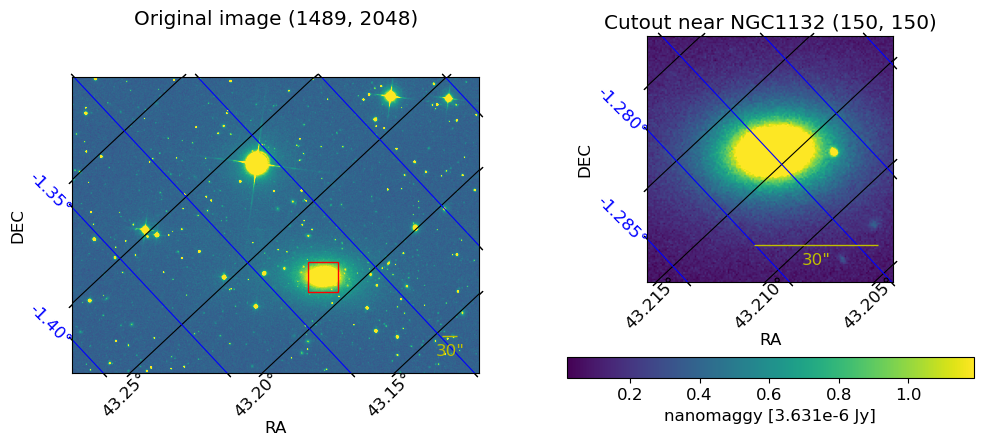

In [2]:
from astropy import units as u

fig = plt.figure(figsize=(10, 5))
ax0 = plt.subplot(121, projection=ccd_orig.wcs)
ax1 = plt.subplot(122, projection=ccd.wcs)

vis.norm_imshow(ax0, data_orig, zscale=True)
im = vis.norm_imshow(ax1, data, zscale=True)
vis.colorbaring(fig, ax1, im, fmt="%.1f", pad=0.2, label="nanomaggy [3.631e-6 Jy]")
for i, (ax, sp) in enumerate(zip([ax0, ax1], [0.05, 0.005])):
    lon, lat = ax.coords
    lon.set_axislabel("RA", minpad=0.5)
    lat.set_axislabel("DEC", minpad=0.5)
    lon.set_major_formatter('d.dd' + "d"*i)
    lat.set_major_formatter('d.dd' + "d"*i)
    lon.set_ticks(spacing=sp*u.deg)  # or, e.g., number=4
    lat.set_ticks(spacing=sp*u.deg) 
    lon.set_ticklabel(color='k', rotation=45, ha='left', va="bottom", rotation_mode='anchor')
    lat.set_ticklabel(color='b', rotation=-45, ha='left', va="bottom", rotation_mode='anchor')
    lon.grid(True, color='k', ls='-')
    lat.grid(True, color='b', ls='-')
    add_scalebar(ax, length=30*u.arcsec, color='y', label='30"', corner='bottom right')
    # lon.set_ticks_position('bt')
    # lon.set_ticklabel_position('bt')
    # lon.set_axislabel_position('bt')
    # lat.set_ticks_position('lr')
    # lat.set_ticklabel_position('lr')
    # lat.set_axislabel_position('lr')

rec = Rectangle((1260-75, 480-75), 150, 150, fc='none', ec='r')
ax0.add_patch(rec)

ax0.set_title(f"Original image {ccd_orig.shape}", y=1.15)
ax1.set_title(f"Cutout near NGC1132 {ccd.shape}")
plt.tight_layout()
plt.show()

In [3]:
box_size = 50
filter_size = 9

avg, med, std = sigma_clipped_stats(data_orig, sigma=3, maxiters=5)
mask = data_orig  > med + 2*std
bkg = Background2D(data_all, mask=mask, box_size=box_size, filter_size=filter_size, exclude_percentile=5)
fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

#axs[0].
# vis.norm_imshow(axs, data_all - bkg.background, zscale=True)
vis.norm_imshow(axs[0], data_all, zscale=True)
vis.norm_imshow(axs[0], mask, alpha=0.5, cmap='Reds')
im = vis.norm_imshow(axs[1], bkg.background, zscale=True)
vis.colorbaring(fig, axs[1], im, fmt="%.3f", pad=0.1, label="nanomaggy [3.631e-6 Jy]")
axs[0].set(title="Image with Mask (faint red)")
axs[1].set(title="Background estimation")
plt.tight_layout()
plt.show();


NameError: name 'data_all' is not defined

In [4]:
sigma = 3.0 * gaussian_fwhm_to_sigma    # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

avg, med, std = sigma_clipped_stats(data, sigma=3, maxiters=5, std_ddof=1)
threshold = med + 3 * std
segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)

fig, axs = plt.subplots(1, 2, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw=None)
axs[0].imshow(segm, origin='lower', cmap=segm.make_cmap(random_state=12345))
axs[1].imshow(segm, origin='lower', cmap=segm.make_cmap(random_state=12345))
axs[1].imshow(data, origin='lower', alpha=0.9)

axs[0].set_title("Segmentation of Sources")
axs[1].set_title("Overplotted with data")
plt.tight_layout()

TypeError: detect_sources() got an unexpected keyword argument 'filter_kernel'